Problem 2: Auto-encoding Retinal Fundus Images
---------------------------------------

You are provided with DRIVE retinal dataset as ‘DRIVEdata.mat’. It has 2 matrices, ‘DataMatrix’ of size 40,000x625, i.e. 40,000 retinal image patches of size 25x25 centered at a vessel or background. ‘Labels’ is the class label ‘0 1’ or ‘1 0’ (2 Classes binary Encoded, vessel and background). Split the data into Training and Testing as 80- 20%.
Tasks:
1. Autoencode the Data with 50 hidden units selecting a decent learning rate for
convergence.
2. Use the 50 dimensional learnt features to train a Random Forest and a Logistic
Regression Classifier (Use any inbuilt or open source code for Random Forest
and Logistic Regression).
3. Compare their performance on the 20% testing data and report them. 
4. Visualize the learnt weights.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.layers import Input, Dense
from keras.models import Model

import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
mat_contents = sio.loadmat('DRIVEdata.mat')
x = mat_contents['DataMatrix']
y = mat_contents['Labels']

# Replace value in y: [0 1] -> 1 and [1 0] -> 2
y = y[:,0]
y = np.where(y == 1, 2, 1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

(32000, 625) train samples
(8000, 625) test samples


In [3]:
# Normalize features
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train.shape,X_test.shape

((32000, 625), (8000, 625))

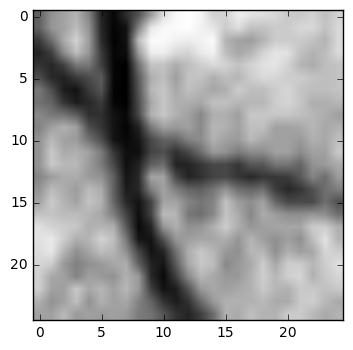

In [4]:
plt.imshow(x[0].reshape(25, 25))
plt.gray()

plt.show()

**1. Autoencode the Data with 50 hidden units selecting a decent learning rate for
convergence.**

In [5]:
def create_autoencoder(num_features, encoding_dim=50, learning_rate=0.5):
    # this is our input placeholder
    input_img = Input(shape=(num_features,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(num_features, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input=input_img, output=decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input=input_img, output=encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))

    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    # create the decoder model
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

    # Adadelta optimizer
#     optimizer_adadelta = keras.optimizers.Adadelta(lr=learning_rate)
#     autoencoder.compile(optimizer=optimizer_adadelta, loss='binary_crossentropy')
    
    # Stochastic gradient descent optimizer
    optimizer_SGD = keras.optimizers.SGD(lr=learning_rate, momentum=0.25)
    autoencoder.compile(optimizer=optimizer_SGD, loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [6]:
# Settings for Autoencoder

# number of epochs
nb_epoch = 50

# learning rate
learning_rate = 0.5 # default=1 when using adadelta optimizer, use lr < 1 when using SGD

# number of features (25*25)
num_features = X_train.shape[1]

In [7]:
# this is the size of our encoded representations (number of hidden layers)
encoding_dim = 50  

encoder, decoder, autoencoder = create_autoencoder(num_features, encoding_dim, learning_rate)

AE_50 = autoencoder.fit(X_train, X_train,
                nb_epoch=nb_epoch,
                shuffle=True,
                validation_data=(X_train, X_train))

Train on 32000 samples, validate on 32000 samples
Epoch 1/50
32000/32000 [==============================] - 9s - loss: 0.6917 - val_loss: 0.6904
Epoch 2/50
32000/32000 [==============================] - 7s - loss: 0.6894 - val_loss: 0.6885
Epoch 3/50
32000/32000 [==============================] - 8s - loss: 0.6876 - val_loss: 0.6866
Epoch 4/50
32000/32000 [==============================] - 8s - loss: 0.6856 - val_loss: 0.6844
Epoch 5/50
32000/32000 [==============================] - 8s - loss: 0.6831 - val_loss: 0.6816
Epoch 6/50
32000/32000 [==============================] - 10s - loss: 0.6796 - val_loss: 0.6771
Epoch 7/50
32000/32000 [==============================] - 10s - loss: 0.6731 - val_loss: 0.6694
Epoch 8/50
32000/32000 [==============================] - 8s - loss: 0.6671 - val_loss: 0.6652
Epoch 9/50
32000/32000 [==============================] - 7s - loss: 0.6641 - val_loss: 0.6634
Epoch 10/50
32000/32000 [==============================] - 7s - loss: 0.6628 - val_loss: 0.66

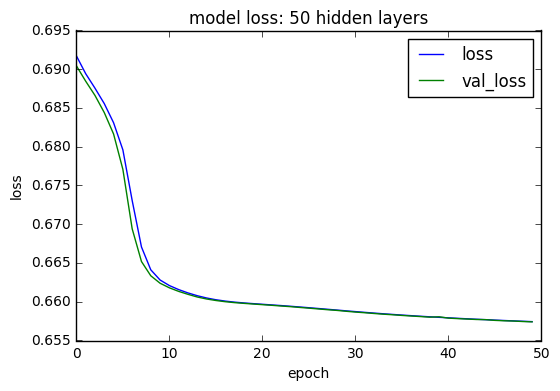

In [8]:
loss_list = AE_50.history.get('loss')
val_loss_list = AE_50.history.get('val_loss')

# summarize history for loss
plt.plot(loss_list)
plt.plot(val_loss_list)
plt.title('model loss: 50 hidden layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

**2. Use the 50 dimensional learnt features to train a Random Forest and a Logistic
Regression Classifier (Use any inbuilt or open source code for Random Forest
and Logistic Regression).**


In [9]:
#decoded_imgs = decoder.predict(encoded_imgs)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

In [10]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_confusion_matrix_performance(cnf_matrix, classes, model_name=""):
    # Plot non-normalized confusion matrix
    # plt.figure()
    # plot_confusion_matrix(cnf_matrix, classes=class_names,
    #                           title=model_name + ' Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                              title=model_name)
    plt.show()
    
    TP = cnf_matrix[0,0]
    FN = cnf_matrix[0,1]
    FP = cnf_matrix[1,0]
    TN = cnf_matrix[1,1]

    accuracy = (TN+TP)/(TP+FN+FP+TN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    print("Accuracy: %f" % accuracy)
    print("Sensitivity: %f" % sensitivity)
    print("Specificity: %f" % specificity)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Classfier 1: Train random forest classifier with 20 trees and max depth of 4. (Encoded data)
clf_randomforest = RandomForestClassifier(n_estimators=20, max_depth=4)
clf_randomforest.fit(X_train_encoded, y_train)
y_pred = clf_randomforest.predict(X_test_encoded)

cnf_matrix_encode_randomforest = confusion_matrix(y_test, y_pred)

# Classfier 2: Train random forest classifier with 20 trees and max depth of 4. (Normal)
clf_randomforest = RandomForestClassifier(n_estimators=20, max_depth=4)
clf_randomforest.fit(X_train, y_train)
y_pred = clf_randomforest.predict(X_test)

cnf_matrix_normal_randomforest = confusion_matrix(y_test, y_pred)


In [12]:
from sklearn import linear_model


# Classfier 3: Train logistic regression classifier (Encoded data)
clf_logreg = linear_model.LogisticRegression()
clf_logreg.fit(X_train_encoded, y_train)
y_pred = clf_logreg.predict(X_test_encoded)

cnf_matrix_encode_logreg = confusion_matrix(y_test, y_pred)

# Classfier 4: Train logistic regression classifier  (Normal)
clf_logreg = linear_model.LogisticRegression()
clf_logreg.fit(X_train, y_train)
y_pred = clf_logreg.predict(X_test)

cnf_matrix_normal_logreg = confusion_matrix(y_test, y_pred)


**3. Compare their performance on the 20% testing data and report them.**

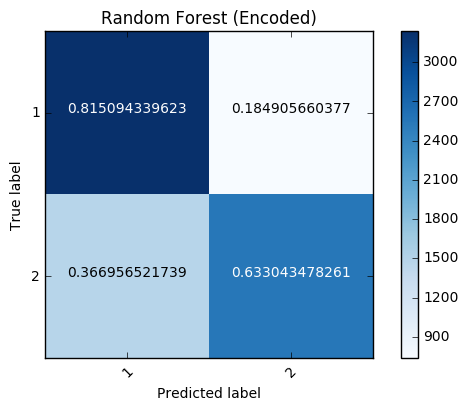

Accuracy: 0.723500
Sensitivity: 0.815094
Specificity: 0.633043


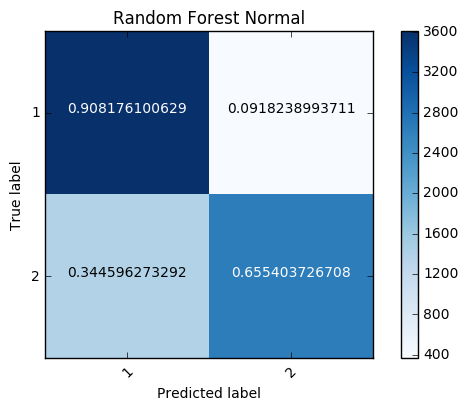

Accuracy: 0.781000
Sensitivity: 0.908176
Specificity: 0.655404


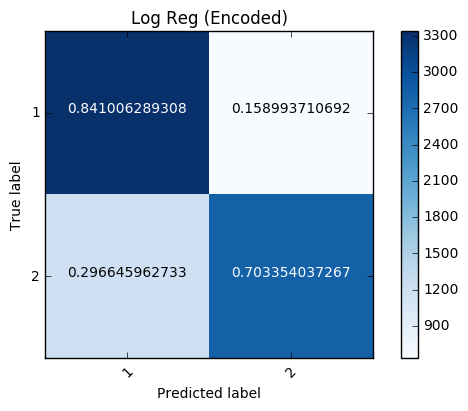

Accuracy: 0.771750
Sensitivity: 0.841006
Specificity: 0.703354


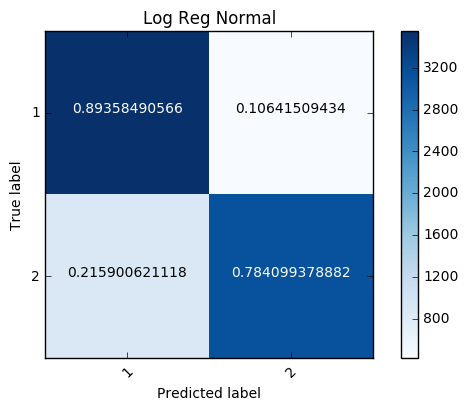

Accuracy: 0.838500
Sensitivity: 0.893585
Specificity: 0.784099


In [13]:
class_names = np.unique(y)

plot_confusion_matrix_performance(cnf_matrix=cnf_matrix_encode_randomforest, classes=class_names,model_name="Random Forest (Encoded)")
plot_confusion_matrix_performance(cnf_matrix=cnf_matrix_normal_randomforest, classes=class_names,model_name="Random Forest Normal")

plot_confusion_matrix_performance(cnf_matrix=cnf_matrix_encode_logreg, classes=class_names,model_name="Log Reg (Encoded)")
plot_confusion_matrix_performance(cnf_matrix=cnf_matrix_normal_logreg, classes=class_names,model_name="Log Reg Normal")

**4. Visualize the learnt weights.**

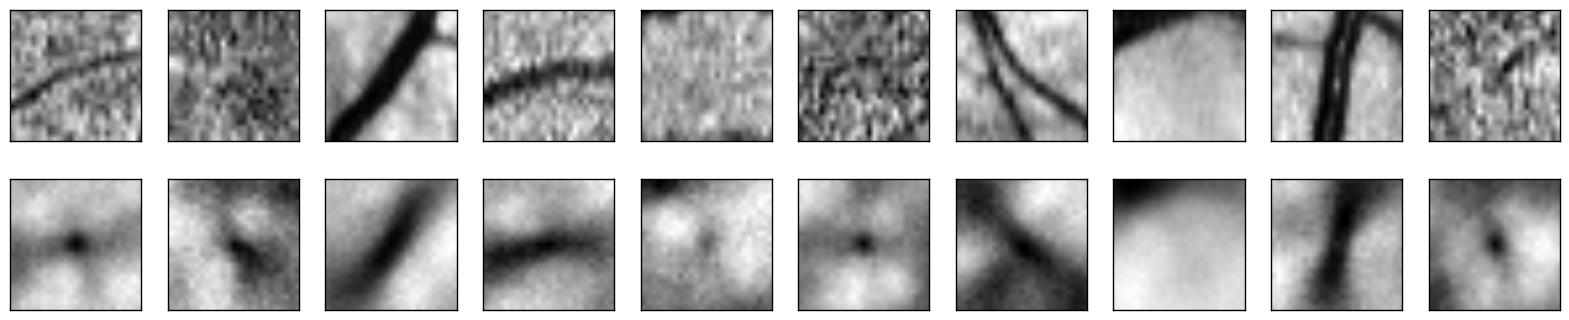

In [14]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(25, 25))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(25, 25))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()